Null values per column:
 ROPOLine                          0
Task Order                        0
Condom Adjusted Task Order        0
Country                           0
RO Number                         0
                              ...  
Pick Up                       21150
Deliver                       15343
Quality Assurance             38560
Reason Code                   14282
Reason Code Duration          21548
Length: 104, dtype: int64

Training models for 'OTIF Status':
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.62      0.43      1842
           1       0.86      0.64      0.73      6568

    accuracy                           0.64      8410
   macro avg       0.59      0.63      0.58      8410
weighted avg       0.74      0.64      0.67      8410

AUC-ROC: 0.7042
Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.73     

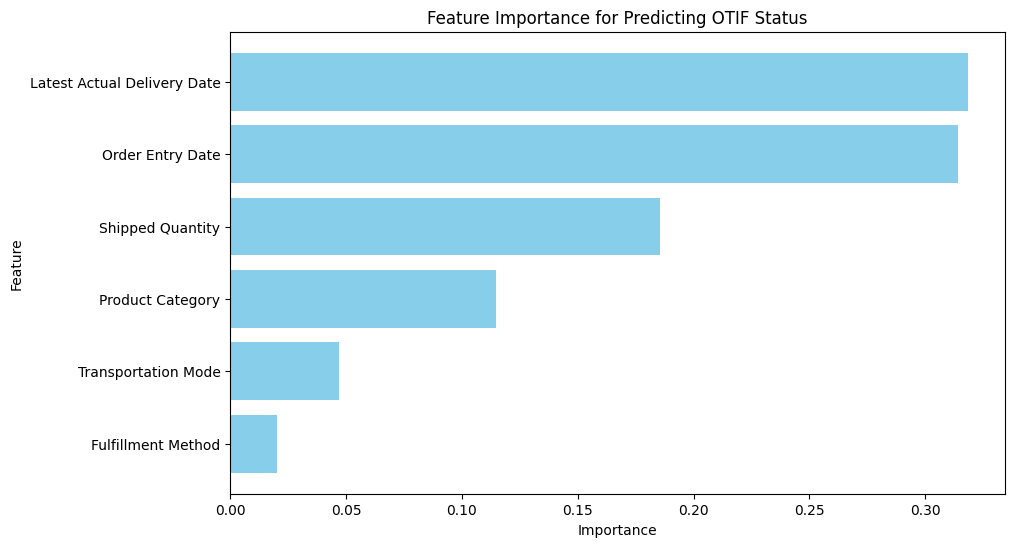

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(r'C:\Users\lavan\OneDrive\Documents\DSCI5260\final project dataset.csv', low_memory=False)

print("Null values per column:\n", df.isnull().sum())

df['Order Entry Date'] = pd.to_datetime(df['Order Entry Date'], errors='coerce')
df['Agreed Delivery Date'] = pd.to_datetime(df['Agreed Delivery Date'], errors='coerce')
df['Latest Actual Delivery Date'] = pd.to_datetime(df['Latest Actual Delivery Date'], errors='coerce')
df.dropna(subset=['Order Entry Date', 'Agreed Delivery Date', 'Latest Actual Delivery Date'], inplace=True)
df['Delivery Time'] = (df['Agreed Delivery Date'] - df['Order Entry Date']).dt.days
df['OTIF Status'] = ((df['In Full (IFD)'] == 'Y') & (df['On Time (OTD)'] == 'Y')).astype(int)
columns_of_interest = ['Fulfillment Method', 'Transportation Mode', 'Product Category', 
                       'Shipped Quantity', 'Order Entry Date', 'Latest Actual Delivery Date', 
                       'Delivery Time', 'OTIF Status']
df_selected = df[columns_of_interest]
df_selected['Order Entry Date'] = (df_selected['Order Entry Date'] - df_selected['Order Entry Date'].min()).dt.days
df_selected['Latest Actual Delivery Date'] = (df_selected['Latest Actual Delivery Date'] - df_selected['Latest Actual Delivery Date'].min()).dt.days
categorical_features = df_selected.select_dtypes(include="object").columns
for feature in categorical_features:
    df_selected[feature] = LabelEncoder().fit_transform(df_selected[feature].astype(str))
df_selected.fillna(df_selected.median(), inplace=True)
X = df_selected.drop(['Delivery Time', 'OTIF Status'], axis=1)
y1 = df_selected['Delivery Time']
y2 = df_selected['OTIF Status']
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

# Use SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y2_train_balanced = smote.fit_resample(X_train, y2_train)

# Scale features
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

# Train and Evaluate Classification Models
print("\nTraining models for 'OTIF Status':")
models_classification = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
}

for name, model in models_classification.items():
    model.fit(X_train_balanced, y2_train_balanced)
    y2_test_pred = model.predict(X_test)
    print(f"{name} Classification Report:")
    print(classification_report(y2_test, y2_test_pred))
    print(f"AUC-ROC: {roc_auc_score(y2_test, model.predict_proba(X_test)[:, 1]):.4f}")
    print("=" * 50)

# Analyze Predictor Importance (for Random Forest)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_balanced, y2_train_balanced)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances (Random Forest):")
print(feature_importance)

# Visualize Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Predicting OTIF Status')
plt.gca().invert_yaxis()
plt.show()


1. Handling Null Values
We'll fill missing values in a more nuanced way:

Numerical Columns: Use mean or median imputation depending on skewness.
Categorical Columns: Use mode or a placeholder value (e.g., "Unknown").

In [7]:
# Fill missing values
numerical_cols = df_selected.select_dtypes(include="number").columns
categorical_cols = df_selected.select_dtypes(include="object").columns

# Impute numerical columns with median
df_selected[numerical_cols] = df_selected[numerical_cols].fillna(df_selected[numerical_cols].median())

# Impute categorical columns with mode
df_selected[categorical_cols] = df_selected[categorical_cols].fillna("Unknown")


2. Hyperparameter Tuning for Random Forest
We’ll use GridSearchCV to find the optimal parameters for the Random Forest model.

In [8]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

# Initialize GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, scoring='f1', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_balanced, y2_train_balanced)

# Best parameters
print("Best parameters from GridSearchCV:", grid_search.best_params_)

# Train final model with best parameters
best_rf = grid_search.best_estimator_


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters from GridSearchCV: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


3. Adjusting Class Weights
To improve predictions for the minority class, we can adjust class weights in both models.

In [9]:
# Logistic Regression with class weights
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train_balanced, y2_train_balanced)

# Random Forest with class weights
rf = RandomForestClassifier(class_weight={0: 2, 1: 1}, random_state=42)  # Adjust weights
rf.fit(X_train_balanced, y2_train_balanced)


RandomForestClassifier(class_weight={0: 2, 1: 1}, random_state=42)

4. Threshold Adjustment for Classification
Adjust the probability threshold for class predictions to improve recall for the minority class.

In [ ]:
# Predict probabilities
y2_probs = rf.predict_proba(X_test)[:, 1]

# Adjust threshold
threshold = 0.4  # default is 0.5
y2_test_pred_adj = (y2_probs > threshold).astype(int)

# Evaluate adjusted predictions
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y2_test, y2_test_pred_adj))
print("Classification Report with Adjusted Threshold:")
print(classification_report(y2_test, y2_test_pred_adj))


Confusion Matrix with Adjusted Threshold:
[[1276  566]
 [ 345 6223]]
Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      1842
           1       0.92      0.95      0.93      6568

    accuracy                           0.89      8410
   macro avg       0.85      0.82      0.83      8410
weighted avg       0.89      0.89      0.89      8410



5. Advanced Models
Try Gradient Boosting models like XGBoost or LightGBM for enhanced performance.

In [11]:
from xgboost import XGBClassifier

# Initialize XGBoost model
xgb = XGBClassifier(scale_pos_weight=len(y2_train_balanced) / sum(y2_train_balanced == 0), 
                     random_state=42)
xgb.fit(X_train_balanced, y2_train_balanced)

# Predict and evaluate
y2_test_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y2_test, y2_test_pred_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.59      0.66      1842
           1       0.89      0.94      0.92      6568

    accuracy                           0.87      8410
   macro avg       0.82      0.77      0.79      8410
weighted avg       0.86      0.87      0.86      8410



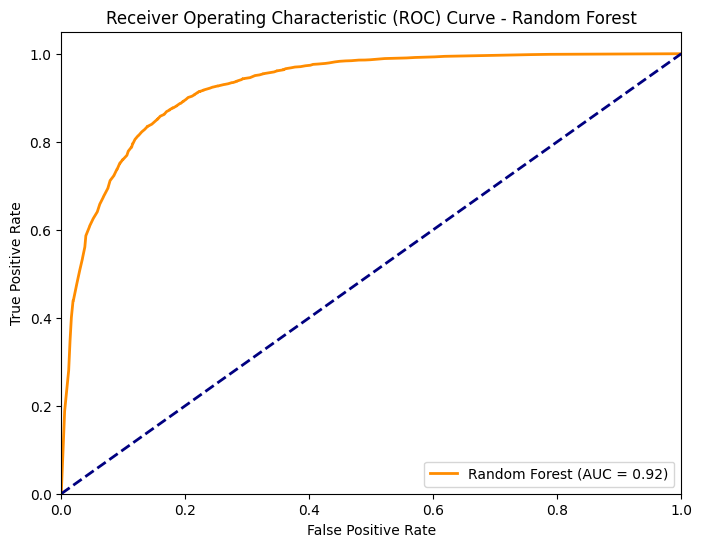

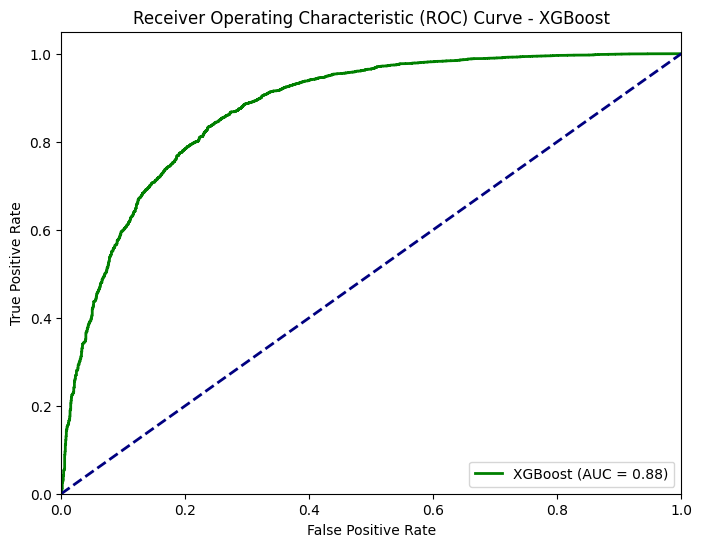

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC curve for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y2_test, rf.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

# Generate ROC curve for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y2_test, xgb.predict_proba(X_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc='lower right')
plt.show()


3. Model Interpretation
Feature Importance (Random Forest):
You've already calculated feature importance using Random Forest. Let’s interpret the results:

python
Copy code



Feature Importances (Random Forest):
                       Feature  Importance
5  Latest Actual Delivery Date    0.320829
4             Order Entry Date    0.303039
3             Shipped Quantity    0.197612
2             Product Category    0.112815
1          Transportation Mode    0.042390
0           Fulfillment Method    0.023315


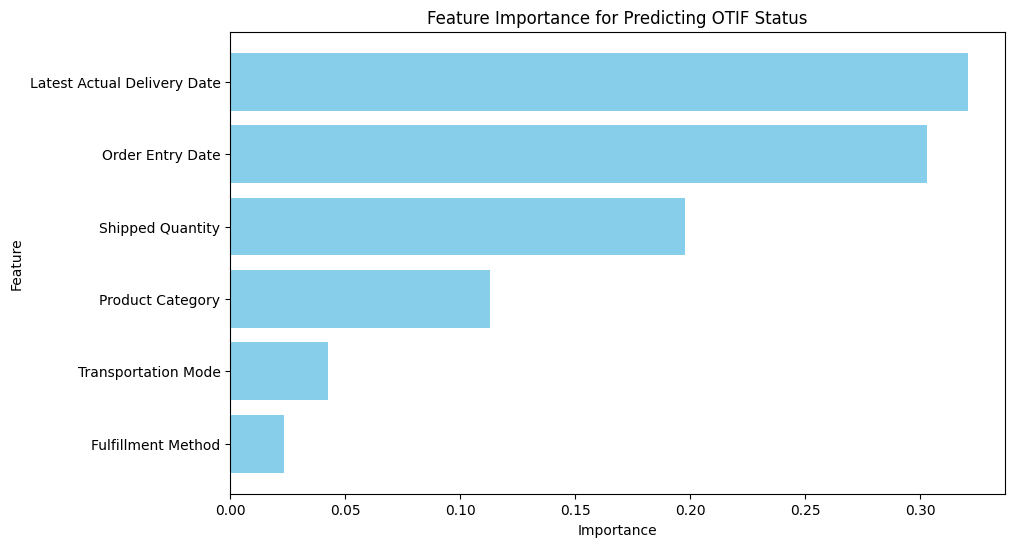

In [18]:
# Feature Importances from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances (Random Forest):")
print(feature_importance)

# Visualize Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Predicting OTIF Status')
plt.gca().invert_yaxis()
plt.show()


Model deployment : since i have laready choosen random forest classifer as the best model

In [20]:
import joblib

# Save the Random Forest model
joblib.dump(rf, 'random_forest_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

loading the model for predection

In [ ]:
# Load the saved model
rf_loaded = joblib.load('random_forest_model.pkl')
scaler_loaded = joblib.load('scaler.pkl')

# Sample prediction with new data
new_data = np.array([[1, 3, 2, 10, 100, 150]])  # Replace with actual new data
new_data_scaled = scaler_loaded.transform(new_data)
prediction = rf_loaded.predict(new_data_scaled)
print(f"Prediction for new data: {prediction}")


Prediction for new data: [0]


In [22]:
import joblib

# Saving the trained Random Forest model
joblib.dump(rf, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [23]:
# Load the saved scaler and model
scaler = joblib.load('scaler.pkl')
rf_model = joblib.load('random_forest_model.pkl')


In [ ]:
#  Model for prediction with new data and predict using the saved Random Forest model
new_data = pd.DataFrame({
    'Fulfillment Method': [1],  
    'Transportation Mode': [3],  
    'Product Category': [1],  
    'Shipped Quantity': [100],  
    'Order Entry Date': [30],  
    'Latest Actual Delivery Date': [35] 
})

new_data_scaled = scaler.transform(new_data)

prediction = rf_model.predict(new_data_scaled)
print(f"Prediction for new data: {prediction}")


Prediction for new data: [0]
